# We will use the donkeycar categorical method, which uses linear_bin & unbin to categorize the angles into their respective category.

# I am using GPU to speed up my code run time. 
# Delete this block if you do not need it 

In [42]:
import plaidml.keras
import os
plaidml.keras.install_backend()
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

# 1. Load packages and paste functions from donkeycar utils.py
# 2. Create lists to append angle, image array value and 1 hot encoded angle category. Use linear_bin to convert angles to 1 hot encoding

In [69]:
%%time

import os 
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import random
import json
from matplotlib import image
import matplotlib.pyplot as plt
import numpy


def clamp(n, min, max):
    if n < min:
        return min
    if n > max:
        return max
    return n

def linear_bin(a, N=15, offset=1, R=2.0):
    '''
    create a bin of length N
    map val A to range R
    offset one hot bin by offset, commonly R/2
    '''
    a = a + offset
    b = round(a / (R/(N-offset)))
    arr = np.zeros(N)
    b = clamp(b, 0, N - 1)
    arr[int(b)] = 1
    return arr


def linear_unbin(arr, N=15, offset=-1, R=2.0):
    '''
    preform inverse linear_bin, taking
    one hot encoded arr, and get max value
    rescale given R range and offset
    '''
    b = np.argmax(arr)
    a = b *(R/(N + offset)) + offset
    return a


angle_results = []
image_list = []
encoded_category = []

throttle_results = []
encoded_throttle_category = []


filepath = "C:\\Users\\kansh\\projects\\mycar\\data\\tub_280_20-02-01\\" 
filenames = sorted(os.listdir(filepath), key=len)

for filename in filenames: 
    if filename.endswith(".json") and not filename.startswith("meta"):
            with open(filepath+filename, 'r') as read_file:
            
                json_data = json.load(read_file)                  
                x = float(json_data['user/angle'])
                y = float(json_data['user/throttle'])
                
                angle_results.append(x)
                throttle_results.append(y)

                encoded_category.append(linear_bin(x))
                encoded_throttle_category.append(linear_bin(y, N=20, offset=0,R=0.5))
                
    if filename.endswith(".jpg") and not filename.endswith(".json"):
        im=image.imread(filepath+filename)
        image_list.append(im)

print(angle_results[0:3], "\n")
print(encoded_category[0:3], "\n")
print(image_list[0:3],"\n\n")

print(throttle_results[0:3], "\n")
print(encoded_throttle_category[0:3], "\n")

[-0.02853175571986613, -0.02853175571986613, -0.03566480364118334] 

[array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])] 

[array([[[ 42,  41,  11],
        [ 38,  37,   6],
        [ 40,  39,   8],
        ...,
        [ 71,  87,  76],
        [ 71,  87,  77],
        [ 83,  99,  89]],

       [[ 49,  48,  18],
        [ 37,  36,   5],
        [ 32,  31,   0],
        ...,
        [ 75,  91,  78],
        [ 69,  85,  72],
        [ 78,  94,  81]],

       [[ 56,  55,  25],
        [ 37,  36,   5],
        [ 26,  25,   0],
        ...,
        [ 73,  88,  69],
        [ 77,  92,  73],
        [ 94, 109,  90]],

       ...,

       [[130, 126, 125],
        [131, 127, 126],
        [133, 129, 128],
        ...,
        [129, 129, 129],
        [131, 131, 131],
        [137, 137, 137]],

       [[130, 126, 125],
        [131, 127, 126

# 3. Convert image and 1 hot encoded lists into array, define as X, Y and Z
# 4. Split them into 80/20 for X_train,X_test,Y_train,Y_test, Z_train, Z_test

In [44]:
array_image_list = np.array(image_list)
print(array_image_list.shape)

array_ec = np.array(encoded_category)
print(array_ec.shape)

array_etc = np.array(encoded_throttle_category)
print(array_etc.shape)

(4917, 120, 160, 3)
(4917, 15)
(4917, 20)


In [45]:
X = array_image_list
Y = array_ec
Z = array_etc

X_train, X_test, Y_train, Y_test, Z_train, Z_test = train_test_split(X,Y,Z, test_size=0.2, 
                                                                     random_state=42
                                                                    )

# 5. This model is taken from donkeycar's categorical architecture
# A Functional API Model is used for multiple outputs instead of Sequential Model (only 1 input & 1 output)

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense


input_shape=(120, 160, 3)
opt = keras.optimizers.Adam(lr=0.001,decay=0.0)
drop = 0.2

img_in = Input(shape=input_shape, name='img_in')             
x = img_in
x = Conv2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1")(x)      
x = Dropout(drop)(x)                                                     
x = Conv2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2")(x)    
x = Dropout(drop)(x)                                                 
if input_shape[0] > 32 :
    x = Conv2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3")(x)
else:
    x = Conv2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_3")(x)       
if input_shape[0] > 64 :
    x = Conv2D(64, (3,3), strides=(2,2), activation='relu', name="conv2d_4")(x)       
elif input_shape[0] > 32 :
    x = Conv2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_4")(x)      
x = Dropout(drop)(x)                                                      
x = Conv2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5")(x)     
x = Dropout(drop)(x)                                                   


x = Flatten(name='flattened')(x)                                      
x = Dense(100, activation='relu', name="fc_1")(x)                       
x = Dropout(drop)(x)                                                      
x = Dense(50, activation='relu', name="fc_2")(x)                                
x = Dropout(drop)(x)           

#categorical output of the angle
angle_out = Dense(15, activation='softmax', name='angle_out')(x)    
#continous output of throttle #20
throttle_out = Dense(20, activation='softmax', name='throttle_out')(x) 
    
model = Model(inputs=[img_in], outputs=[angle_out, throttle_out])

model.compile(loss={'angle_out': 'categorical_crossentropy', 
                    'throttle_out': 'categorical_crossentropy'},
                    optimizer=opt, metrics=['acc'])


model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_in (InputLayer)             [(None, 120, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 58, 78, 24)   1824        img_in[0][0]                     
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 58, 78, 24)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 27, 37, 32)   19232       dropout_6[0][0]                  
____________________________________________________________________________________________

# 6. Use learn rate reduction to improve metric

In [47]:
from tensorflow.keras.callbacks import ReduceLROnPlateau


learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=1,  
                                            verbose=1, 
                                            mode='min',
                                            factor=0.2, 
                                            min_lr=0.001 
                                           ) 
callbacks = [learning_rate_reduction]

# 7. Run training
# Since our model has two outputs, the two arrays (ec and etc) have to be fitted. To do this, the 'x' will contain 'x_train' and the 'y' will contain 'y_train and z_train' similar for validation data.


In [49]:
%%time

epochs = 100
batch_size = 128
steps = 100

history = model.fit(
                    x = X_train, y = [Y_train,Z_train],
                    epochs=epochs,
                    validation_data=[X_test,[Y_test,Z_test]], 
                    callbacks=callbacks
                   )   


Train on 3933 samples, validate on 984 samples
Epoch 1/100
3933/3933 [==============================] - 115s 29ms/sample - loss: 3.3894 - angle_out_loss: 2.9009 - throttle_out_loss: 0.4879 - angle_out_acc: 0.1271 - throttle_out_acc: 0.9580 - val_loss: 2.6135 - val_angle_out_loss: 2.4316 - val_throttle_out_loss: 0.1802 - val_angle_out_acc: 0.1799 - val_throttle_out_acc: 0.9878
Epoch 2/100
3904/3933 [============================>.] - ETA: 0s - loss: 2.6632 - angle_out_loss: 2.5282 - throttle_out_loss: 0.1349 - angle_out_acc: 0.1522 - throttle_out_acc: 0.9851
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 136s 35ms/sample - loss: 2.6625 - angle_out_loss: 2.5274 - throttle_out_loss: 0.1350 - angle_out_acc: 0.1526 - throttle_out_acc: 0.9853 - val_loss: 2.6295 - val_angle_out_loss: 2.4005 - val_throttle_out_loss: 0.2272 - val_angle_out_acc: 0.2388 - val_throttle_out_acc: 0.9878
Epoch 3/100
3933/3933 [==============================

Epoch 37/100
3904/3933 [============================>.] - ETA: 0s - loss: 1.0297 - angle_out_loss: 1.0146 - throttle_out_loss: 0.0151 - angle_out_acc: 0.6245 - throttle_out_acc: 0.9962
Epoch 00037: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 99s 25ms/sample - loss: 1.0325 - angle_out_loss: 1.0177 - throttle_out_loss: 0.0151 - angle_out_acc: 0.6242 - throttle_out_acc: 0.9962 - val_loss: 1.4554 - val_angle_out_loss: 1.4434 - val_throttle_out_loss: 0.0096 - val_angle_out_acc: 0.5041 - val_throttle_out_acc: 0.9970
Epoch 38/100
3904/3933 [============================>.] - ETA: 0s - loss: 1.0376 - angle_out_loss: 1.0214 - throttle_out_loss: 0.0162 - angle_out_acc: 0.6311 - throttle_out_acc: 0.9956
Epoch 00038: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 111s 28ms/sample - loss: 1.0379 - angle_out_loss: 1.0218 - throttle_out_loss: 0.0161 - angle_out_acc: 0.6316 - throttle_out_acc: 0.9957 - 

Epoch 52/100
3904/3933 [============================>.] - ETA: 0s - loss: 0.8560 - angle_out_loss: 0.8394 - throttle_out_loss: 0.0166 - angle_out_acc: 0.6967 - throttle_out_acc: 0.9974
Epoch 00052: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 98s 25ms/sample - loss: 0.8539 - angle_out_loss: 0.8372 - throttle_out_loss: 0.0165 - angle_out_acc: 0.6979 - throttle_out_acc: 0.9975 - val_loss: 1.5916 - val_angle_out_loss: 1.5712 - val_throttle_out_loss: 0.0158 - val_angle_out_acc: 0.5102 - val_throttle_out_acc: 0.9970
Epoch 53/100
3904/3933 [============================>.] - ETA: 0s - loss: 0.8478 - angle_out_loss: 0.8341 - throttle_out_loss: 0.0137 - angle_out_acc: 0.7036 - throttle_out_acc: 0.9962
Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 99s 25ms/sample - loss: 0.8460 - angle_out_loss: 0.8322 - throttle_out_loss: 0.0136 - angle_out_acc: 0.7040 - throttle_out_acc: 0.9962 - v

Epoch 67/100
3904/3933 [============================>.] - ETA: 0s - loss: 0.7059 - angle_out_loss: 0.6978 - throttle_out_loss: 0.0081 - angle_out_acc: 0.7567 - throttle_out_acc: 0.9969
Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 102s 26ms/sample - loss: 0.7076 - angle_out_loss: 0.6997 - throttle_out_loss: 0.0081 - angle_out_acc: 0.7567 - throttle_out_acc: 0.9969 - val_loss: 1.8166 - val_angle_out_loss: 1.7762 - val_throttle_out_loss: 0.0326 - val_angle_out_acc: 0.5000 - val_throttle_out_acc: 0.9949
Epoch 68/100
3904/3933 [============================>.] - ETA: 0s - loss: 0.7114 - angle_out_loss: 0.7036 - throttle_out_loss: 0.0078 - angle_out_acc: 0.7454 - throttle_out_acc: 0.9962
Epoch 00068: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 99s 25ms/sample - loss: 0.7108 - angle_out_loss: 0.7031 - throttle_out_loss: 0.0077 - angle_out_acc: 0.7462 - throttle_out_acc: 0.9962 - 

Epoch 82/100
3904/3933 [============================>.] - ETA: 0s - loss: 0.6680 - angle_out_loss: 0.6530 - throttle_out_loss: 0.0150 - angle_out_acc: 0.7787 - throttle_out_acc: 0.9964
Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 108s 27ms/sample - loss: 0.6679 - angle_out_loss: 0.6530 - throttle_out_loss: 0.0149 - angle_out_acc: 0.7785 - throttle_out_acc: 0.9964 - val_loss: 1.7296 - val_angle_out_loss: 1.7170 - val_throttle_out_loss: 0.0110 - val_angle_out_acc: 0.5274 - val_throttle_out_acc: 0.9970
Epoch 83/100
3904/3933 [============================>.] - ETA: 0s - loss: 0.6466 - angle_out_loss: 0.6340 - throttle_out_loss: 0.0126 - angle_out_acc: 0.7805 - throttle_out_acc: 0.9974
Epoch 00083: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 131s 33ms/sample - loss: 0.6460 - angle_out_loss: 0.6335 - throttle_out_loss: 0.0125 - angle_out_acc: 0.7811 - throttle_out_acc: 0.9975 -

Epoch 97/100
3904/3933 [============================>.] - ETA: 1s - loss: 0.5744 - angle_out_loss: 0.5673 - throttle_out_loss: 0.0071 - angle_out_acc: 0.8122 - throttle_out_acc: 0.9972
Epoch 00097: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 158s 40ms/sample - loss: 0.5725 - angle_out_loss: 0.5653 - throttle_out_loss: 0.0071 - angle_out_acc: 0.8126 - throttle_out_acc: 0.9972 - val_loss: 1.9298 - val_angle_out_loss: 1.9062 - val_throttle_out_loss: 0.0209 - val_angle_out_acc: 0.4970 - val_throttle_out_acc: 0.9949
Epoch 98/100
3904/3933 [============================>.] - ETA: 0s - loss: 0.5688 - angle_out_loss: 0.5583 - throttle_out_loss: 0.0105 - angle_out_acc: 0.8120 - throttle_out_acc: 0.9967
Epoch 00098: ReduceLROnPlateau reducing learning rate to 0.001.
3933/3933 [==============================] - 111s 28ms/sample - loss: 0.5681 - angle_out_loss: 0.5576 - throttle_out_loss: 0.0104 - angle_out_acc: 0.8118 - throttle_out_acc: 0.9967 -

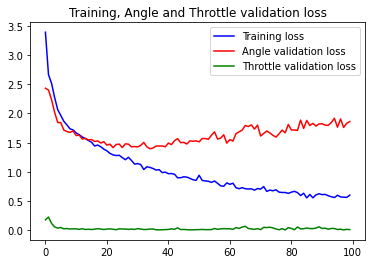

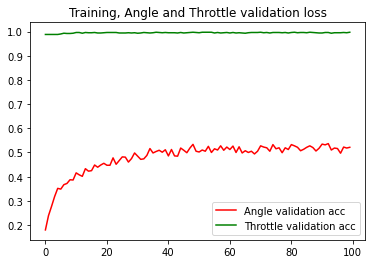

In [50]:
angle_out_acc = history.history['angle_out_acc']
val_angle_out_acc = history.history['val_angle_out_acc']
val_throttle_out_acc = history.history['val_throttle_out_acc']
loss = history.history['loss']
val_angle_out_loss = history.history['val_angle_out_loss']
val_throttle_out_loss = history.history['val_throttle_out_loss']

epochs = range(len(angle_out_acc))

plt.plot(epochs, loss, 'blue', label='Training loss')
plt.plot(epochs, val_angle_out_loss, 'red', label='Angle validation loss')
plt.plot(epochs, val_throttle_out_loss, 'green', label='Throttle validation loss')

plt.title('Training, Angle and Throttle validation loss')
plt.legend()

plt.figure()

plt.plot(epochs, val_angle_out_acc, 'red', label='Angle validation acc')
plt.plot(epochs, val_throttle_out_acc, 'green', label='Throttle validation acc')

plt.title('Training, Angle and Throttle validation loss')
plt.legend(loc='best')

plt.show()

# 8. Save model and load
# 9. Get predictions

In [51]:
model.save('SavedModel6.hdf5')  # creates a HDF5 file 

In [52]:
from tensorflow import keras
from tensorflow.keras.models import load_model

# Load Saved Model
model = load_model('SavedModel6.hdf5', compile = False)

In [53]:
predictions = model.predict(array_image_list)
print(predictions[0:5], "\n\n")
print(predictions[0][0:5],"\n\n")
print(predictions[1][0:5],"\n\n")

[array([[1.0377504e-26, 4.7365137e-25, 6.6107076e-25, ..., 4.9376150e-16,
        4.2947920e-21, 7.0772005e-25],
       [9.0954199e-27, 3.1568389e-25, 5.5923631e-25, ..., 5.8124581e-16,
        7.8648211e-21, 2.4035864e-24],
       [8.5028741e-26, 3.3227851e-24, 4.0842591e-24, ..., 8.7923608e-16,
        1.1129960e-20, 3.7644194e-24],
       ...,
       [0.0000000e+00, 3.0556278e-23, 4.8047133e-26, ..., 2.0036386e-31,
        0.0000000e+00, 0.0000000e+00],
       [2.6297695e-37, 7.1059362e-21, 9.6635739e-23, ..., 1.7584337e-28,
        0.0000000e+00, 0.0000000e+00],
       [1.2326875e-28, 2.8281234e-15, 1.1706951e-16, ..., 4.7757052e-25,
        0.0000000e+00, 0.0000000e+00]], dtype=float32), array([[1.8958071e-15, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [2.5849423e-15, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00],
       [3.6971273e-15, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
 

# 10. Use linear_unbin to decode the 1 hot encoded predictions 
# 11. Plot graph of original angle with predicted angle to compare prediction

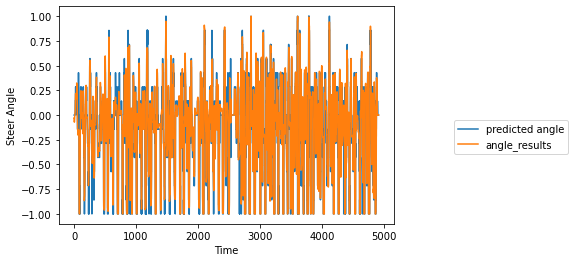

In [64]:
predicted_angle = []
for i in predictions[0]:
    predicted_angle.append(linear_unbin(i))

plt.xlabel("Time")
plt.ylabel("Steer Angle")
plt.plot(predicted_angle, label='predicted angle')
plt.plot(angle_results, label='angle_results')
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
#plt.axis([0,1000,-1.1,1.1])
plt.show()

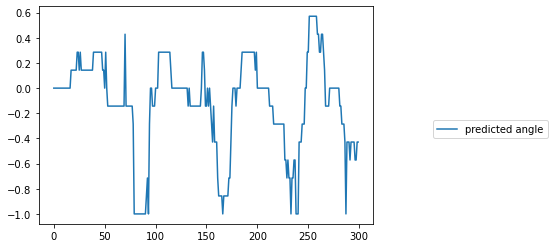

In [55]:
plt.plot(predicted_angle[0:300], label='predicted angle')
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
plt.show()

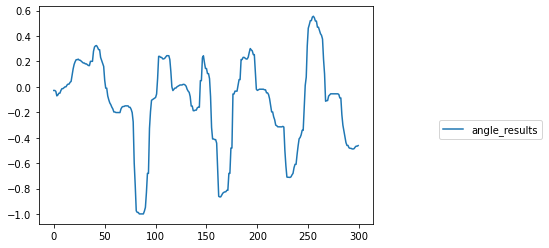

In [56]:
plt.plot(angle_results[0:300], label='angle_results')
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
plt.show()

# 12. Get predicted throttle, remember to linear_unbin with the same (N,offset and R value) as linear_bin throttle
# 13. Plot graph of original throttle with predicted throttle to compare prediction

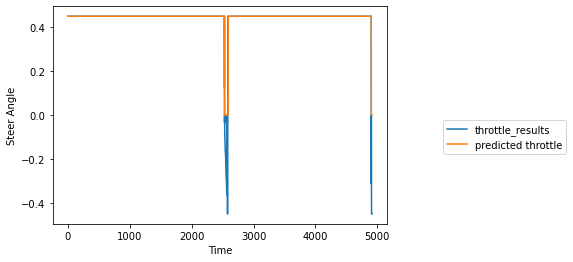

In [65]:
predicted_throttle = []
for i in predictions[1]:
    predicted_throttle.append(linear_unbin(i, N=20, offset=0,R=0.5))

plt.xlabel("Time")
plt.ylabel("Steer Angle")
plt.plot(throttle_results, label='throttle_results')
plt.plot(predicted_throttle, label='predicted throttle')
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
#plt.axis([0,1000,-1.1,1.1])
plt.show()

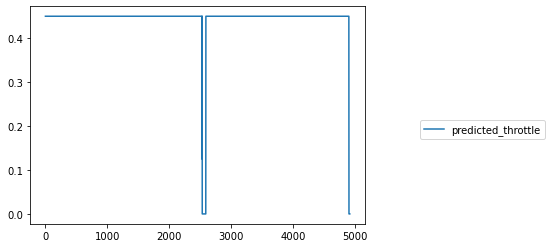

In [58]:
plt.plot(predicted_throttle, label='predicted_throttle')
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
plt.show()

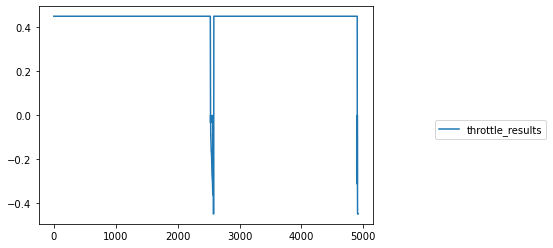

In [59]:
plt.plot(throttle_results, label='throttle_results')
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
plt.show()

# 14. Plot graph of original angle & throttle with predicted angle & throttle to compare

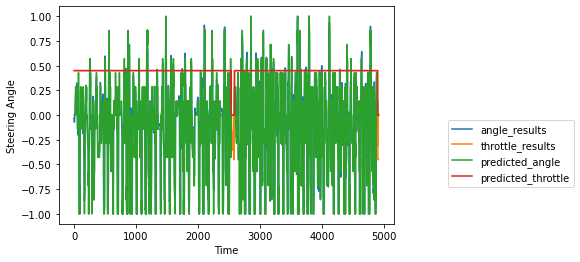

In [67]:
plt.xlabel("Time")
plt.ylabel("Steering Angle")
plt.plot(angle_results,      label='angle_results')
plt.plot(throttle_results,   label='throttle_results')
plt.plot(predicted_angle,    label='predicted_angle') 
plt.plot(predicted_throttle, label='predicted_throttle') 
plt.legend(loc='upper center', bbox_to_anchor=(1.35, 0.5))
plt.show()